### Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import warnings

%matplotlib inline

### Reading Data

In [5]:
rest_data = pd.read_csv("C:/Users/aryan/OneDrive/Desktop/NYU DSGA3001/zomato.csv")

### Data Cleaning

##### Removing Duplicate Entries

In [8]:
rest_data = rest_data.drop_duplicates('url')

##### Removing menu_item as almost all columns are empty lists

In [9]:
rest_data.drop('menu_item',axis=1,inplace=True)

##### Checking for NaNs in relevant columns

In [196]:
#21 null values in location column 
rest_data['location'].isna().sum()

#227 null in rest_type
rest_data['rest_type'].isna().sum()

#20252 null in dish_liked, 28078 null values in dish_liked column without removing any others
rest_data['dish_liked'].isna().sum()

#11 null in dish_liked, 45 null values in dish_liked column without removing any others
rest_data['cuisines'].isna().sum()

#11 null, 45 null values in column without removing any others
rest_data['cuisines'].isna().sum()

#247 null, 346 null values column without removing any others
rest_data['approx_cost(for two people)'].isna().sum()

#0 null, 0 null values column without removing any others
rest_data['reviews_list'].isna().sum()

#'menu_item' dropped in dataset

#0 null, 0 null values column without removing any others
rest_data['listed_in(type)'].isna().sum()

print('We have checked for nulls in the relevant columns')

We have checked for nulls in the relevant columns


##### Dropping NaNs for columns where imputation would not make business sense/harm the problem statement

In [10]:
rest_data.dropna(subset=['rate','location','rest_type','cuisines','approx_cost(for two people)'],inplace=True)

In [25]:
rest_data = rest_data.reset_index()
rest_data.drop('index',axis=1,inplace=True)

In [ ]:
#Data cleaning: 
#Change pricing and any other numerical columns to integers
#Change rate to single number (not x/5)

In [200]:
#Remove commas from the numbers in the approx_cost
#rest_data['approx_cost(for two people)'] = rest_data['approx_cost(for two people)'].str.replace(',', '')

##### Extracting the rating from the 'rate' column (Getting 3.7 from "3.7/5")

In [198]:
rest_data['approx_cost(for two people)'] = rest_data['approx_cost(for two people)'].astype('Int64')

#Keep only the rating and convert to float (remove the '/5' for each entry)
rest_data['rate'] = rest_data['rate'].astype('str')

#Split string by '/'
rest_data['rate'] = rest_data['rate'].str.split('/').str[0]

#Convert to float
rest_data['rate'] = pd.to_numeric(rest_data['rate'], errors = 'coerce')

##### Making a normalized ratings column

In [31]:
ratings_mean = rest_data['rate'].mean()
ratings_std = rest_data['rate'].std()
rest_data['normalized_ratings'] = (rest_data['rate']-ratings_mean)/ratings_std

##### Making a column that counts the cuisines listed on the restaurant

In [41]:
cuisine_count = np.zeros(len(rest_data['cuisines']))

for i in range(len(rest_data['cuisines'])):
    cuisine_count[i] = len(rest_data['cuisines'][i].split(', '))
    
rest_data['cuisines_count'] = cuisine_count

In [203]:
print('The correlation between ratings and the number of cuisines offered is:',rest_data['rate'].corr(rest_data['cuisines_count']))

The correlation between ratings and the number of cuisines offered is: 0.20674347150298625


##### Making columns for cuisines offered at a restaurant (so the data becomes easier to read). The most amount of permitted cuisines on the site is 8, so we have columns from 'cuisine_1' to 'cuisine_8'

In [61]:
cuisine_list = []

for i in range(len(rest_data['cuisines'])):
    cuisine_list.append(rest_data['cuisines'][i].split(', ')) 

rest_data['cuisines_list'] = cuisine_list

In [64]:
rest_data[['cuisine_1', 'cuisine_2', 'cuisine_3','cuisine_4','cuisine_5','cuisine_6','cuisine_7','cuisine_8']] = rest_data['cuisines_list'].apply(
    lambda x: pd.Series([x[0], x[1] if len(x) > 1 else None, x[2] if len(x) > 2 else None, x[3] if len(x) > 3 else None,
                         x[4] if len(x) > 4 else None, x[5] if len(x) > 5 else None, x[6] if len(x) > 6 else None,
                         x[7] if len(x) > 7 else None])
)

##### Making a 'price_range' column that buckets the approx_cost_for_2 ('$','$$','$$$','$$$$')

In [204]:
rest_data['price_range'] = 0
rest_data.loc[rest_data['approx_cost(for two people)'] <= 250, 'price_range'] = '$'
rest_data.loc[(rest_data['approx_cost(for two people)'] >= 250) & (rest_data['approx_cost(for two people)'] < 500), 'price_range'] = '$$'
rest_data.loc[(rest_data['approx_cost(for two people)'] >= 500) & (rest_data['approx_cost(for two people)'] < 1000), 'price_range'] = '$$$'
rest_data.loc[rest_data['approx_cost(for two people)'] >= 1000, 'price_range'] = '$$$$'

### Data Exploration

#### Cuisine 

##### Finding the most popular cuisine based on the number of restaurants listed under that cuisine

In [73]:
rest_data_cuisine = rest_data.copy(deep=True)
rest_data_cuisine.fillna('NaN', inplace=True)
unique_cuisines = np.unique(rest_data_cuisine[['cuisine_1', 'cuisine_2', 'cuisine_3', 'cuisine_4', 'cuisine_5', 'cuisine_6', 'cuisine_7', 'cuisine_8']].values)
unique_cuisines = list(unique_cuisines)

In [85]:
cuisine_count_list = []
for i in range(len(unique_cuisines)):
    rows = rest_data[(rest_data['cuisine_1'] == unique_cuisines[i]) | (rest_data['cuisine_2'] == unique_cuisines[i]) 
                     | (rest_data['cuisine_3'] == unique_cuisines[i]) | (rest_data['cuisine_4'] == unique_cuisines[i])
                     | (rest_data['cuisine_5'] == unique_cuisines[i]) | (rest_data['cuisine_6'] == unique_cuisines[i])
                     | (rest_data['cuisine_7'] == unique_cuisines[i]) | (rest_data['cuisine_8'] == unique_cuisines[i])].index
    cuisine_df = rest_data.iloc[rows]
    cuisine_count_list.append(len(cuisine_df))
    df_name = '{}_df'.format(unique_cuisines[i].replace(' ',''))
    globals()[df_name] = cuisine_df

In [89]:
cuisine_popularity_df = pd.DataFrame()
cuisine_popularity_df['Cuisine'] = unique_cuisines
cuisine_popularity_df['Count'] = cuisine_count_list

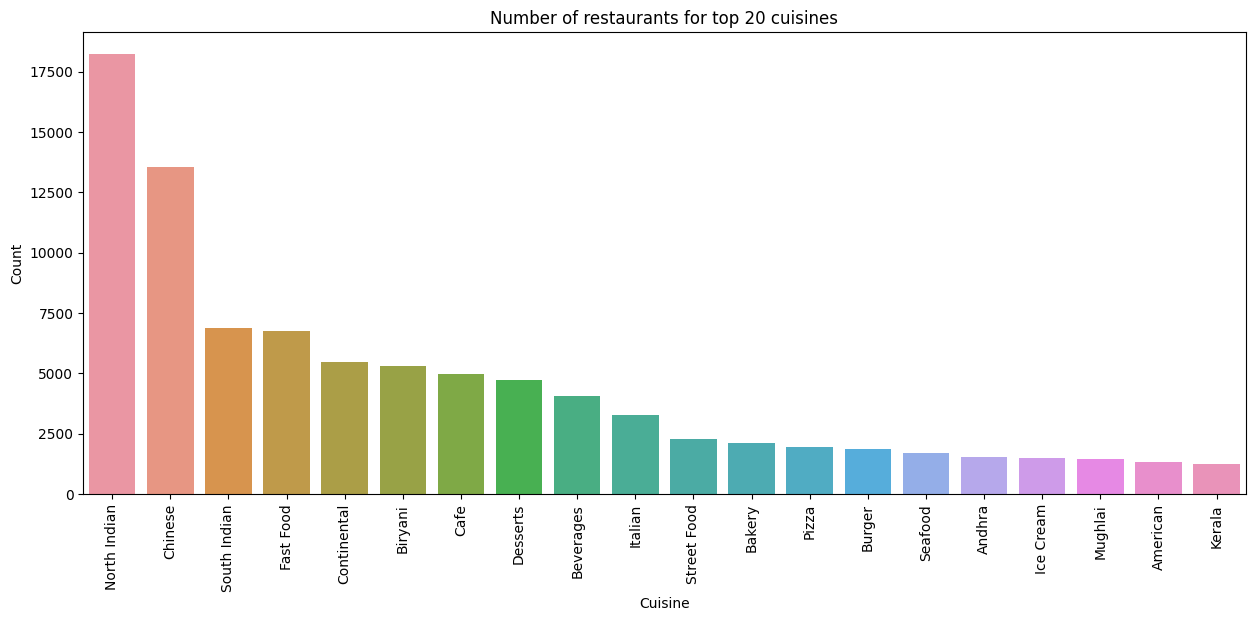

In [219]:
cuisine_popularity_df = cuisine_popularity_df.sort_values(by=['Count'], ascending=False)
cuisine_popularity_df = cuisine_popularity_df.reset_index()
cuisine_popularity_df.drop('index',axis=1,inplace=True)

plt.figure(figsize=(15,6))
sns.barplot(data=cuisine_popularity_df[:20],x = 'Cuisine', y='Count')
plt.title('Number of restaurants for top 20 cuisines')
plt.xticks(rotation=90)
plt.show()

##### The graph below is plotted fromn the original cuisines column and we can see the difference in the results

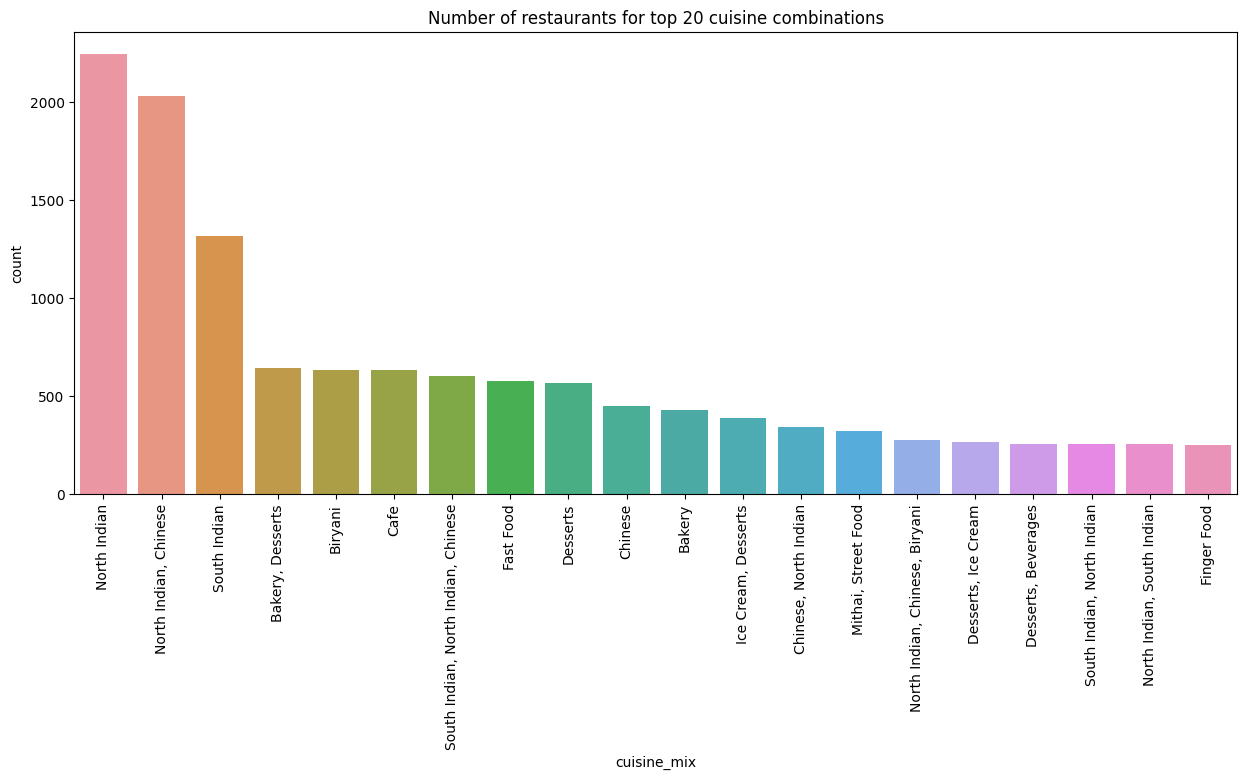

In [218]:
rest_data_mix_cuisine_top = rest_data['cuisines'].value_counts()[:20].rename_axis('cuisine_mix').reset_index(name='count')

plt.figure(figsize=(15,6))
sns.barplot(data=rest_data_mix_cuisine_top,x = 'cuisine_mix', y='count')
plt.title('Number of restaurants for top 20 cuisine combinations')
plt.xticks(rotation=90)
plt.show()

#### Now we look at the distribution of ratings across the top 20 cuisines

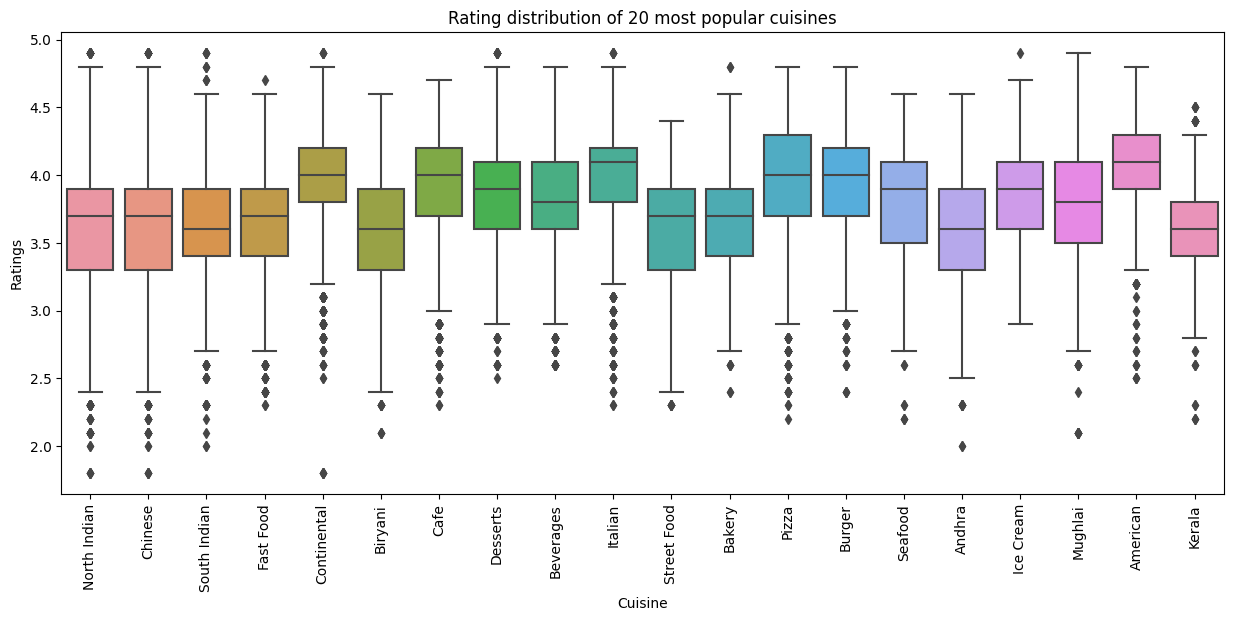

In [220]:
unique_cuisine_top = list(cuisine_popularity_df.head(20)['Cuisine'])
rate_data = []

for cuisine in unique_cuisine_top:
    cuisine_df = globals()['{}_df'.format(cuisine.replace(' ', ''))]
    rate_data.append(cuisine_df['rate'].dropna().tolist())

plt.figure(figsize=(15,6))
sns.boxplot(rate_data)

plt.xticks(range(0, len(unique_cuisine_top)), unique_cuisine_top, rotation=90)
plt.ylabel('Ratings')
plt.xlabel('Cuisine')
plt.title('Rating distribution of 20 most popular cuisines')
plt.show()

##### Distribution of votes across restaurants

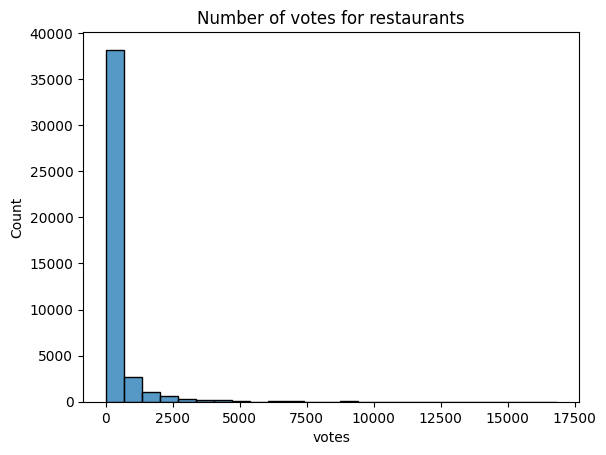

In [221]:
sns.histplot(rest_data['votes'],bins=25)
plt.title('Number of votes for restaurants')
plt.show()

### Building the Ideal Restaurant (Preliminary Approach)

In [222]:
#Aryan Approach
#Location: Most restaurants (Great place to set up as there is demand)
#Cuisine: Highest rated cuisine in that area
#Type: Highest rated type of restaurant in the area
#Budget: Highest rated 'budget-group'

#Mallory Approach
#Location: Highest rated location in the city
#Cuisine: Most popular cuisine in that location
#Type: Most popular type in that cuisine
#Budget: Most popular price_range in that budget

In [163]:
#Finds the location with most restaurants
location1 = rest_data['listed_in(city)'].value_counts().index[0]
location2 = rest_data.groupby('listed_in(city)')['rate'].mean().idxmax()


In [223]:
#Finds the relevant cuisines
cuisine1 = rest_data[rest_data['listed_in(city)'] == location1].groupby('cuisines')['rate'].mean().idxmax()
cuisine2 = rest_data[rest_data['listed_in(city)'] == location2]['cuisines'].value_counts().index[0]

In [224]:
#Finds the ideal restaurant types
type1 = rest_data[(rest_data['listed_in(city)'] == location1) & (rest_data['cuisines'] == cuisine1)].groupby('listed_in(type)')['rate'].mean().idxmax()
type2 = rest_data[(rest_data['listed_in(city)'] == location2) & (rest_data['cuisines'] == cuisine2)]['listed_in(type)'].value_counts().index[0]

In [225]:
#Finds the ideal price range
price_range1 = rest_data[(rest_data['listed_in(city)'] == location1) & (rest_data['cuisines'] == cuisine1) & (rest_data['listed_in(type)'] == type1)].groupby('price_range')['rate'].mean().idxmax()
price_range2 = rest_data[(rest_data['listed_in(city)'] == location2) & (rest_data['cuisines'] == cuisine2) & (rest_data['listed_in(type)'] == type2)]['price_range'].value_counts().index[0]

In [173]:
print('Our Preliminary Answers:\n')
print('Aryan:')
print('Location:',location1)
print('Cuisine:',cuisine1)
print('Type:',type1)
print('Price Range:',price_range1)
print('\n')
print('Mallory:')
print('Location:',location2)
print('Cuisine:',cuisine2)
print('Type:',type2)
print('Price Range:',price_range2)

Our Preliminary Answers:

Aryan:
Location: BTM
Cuisine: Asian, Chinese, Thai, Momos
Type: Buffet
Price Range: $$$$


Mallory:
Location: Church Street
Cuisine: North Indian
Type: Delivery
Price Range: $$
